# Geostrophic balance in the Gulf of Mexico

Although a full description of geophysical flows such as ocean or atmosphere dynamics requires the Navier-Stokes equations on a rotating sphere coupled with an equation of state, etc, many large scale motions are thought to be an approximately steady balance between Coriolis forces and the pressure gradient.

In this notebook we look for geostrophic balance in reanalysis data of surface currents in the Gulf of Mexico, freely available from the [HYCOM group](https://www.hycom.org/).  We make several simplifying assumptions:
* Currents are described by the 2D incompressible, inviscid Navier Stokes equations on a rotating sphere
$$ u_t + (\mathbf{u} \cdot \nabla) u + fv = -\frac{1}{\rho} p_x \\
v_t + (\mathbf{u} \cdot \nabla) v - fu = -\frac{1}{\rho} p_y $$
* Density is constant at 1030 kg/m^3
* Since we don't have access to the pressure fields, we approximate the pressure gradients on the right-hand-side of the above equations with the residual of the left-hand-side

In this case we do look for balance in two dimensions.  Since there is symmetry between the two equations of motion, we just stack terms with the same physical interpretation and put them in the same equation space.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
import scipy.io as sio

import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
%config InlineBackend.figure_format = 'retina'

from matplotlib.colors import ListedColormap

RdBu = plt.get_cmap('RdBu')
RdBu.set_bad('dimgrey')

# Seaborn colormap
import seaborn as sns
sns_list = sns.color_palette('deep').as_hex()
sns_list.insert(0, '#ffffff')  # Insert white at zero position
sns_cmap = ListedColormap(sns_list)

# Switch a few colors for better visualization
sns_list[1:5] = sns_list[2], sns_list[4], '#b3cde3', sns_list[3]

cm = sns_cmap
cm.set_bad('dimgrey')

### Load data and define parameters

In [2]:
data = sio.loadmat('./data/hycom/gom.mat')

lat = data['lat'][:, 0] # degrees
lon = data['lon'][:, 0]
uvel = data['uvel'] # m/s
vvel = data['vvel']
vort = data['vort']
sst = data['temp']

ny = len(lat)
nx = len(lon)
    
lat_rad = np.pi*lat/180;
R_earth = 6370; # Earth's radius (km)
R_lat = R_earth*np.cos(lat_rad);  # Radius as a function of latitude

# Step size as a function of latitude (in m)
#   Based on 1/25 degree resolution
dx = (.04/360)*2*np.pi*R_lat*1000
dt = 3600 # Hourly resolution

# Coriolis parameter
Omega = 7.3e-5 # Rotation rate
f = 2*Omega*np.sin(lat_rad) # s^-1

# Density
rho = 1030 # kg/m^3

### Plot a couple of example fields

In [3]:
def gom_plot(x, y, field, vmin=-1, vmax=1):
    plt.imshow(field, cmap='RdBu', vmin=vmin, vmax=vmax, origin='lower',
               extent=[min(x), max(x), min(y), max(y)], interpolation='gaussian')

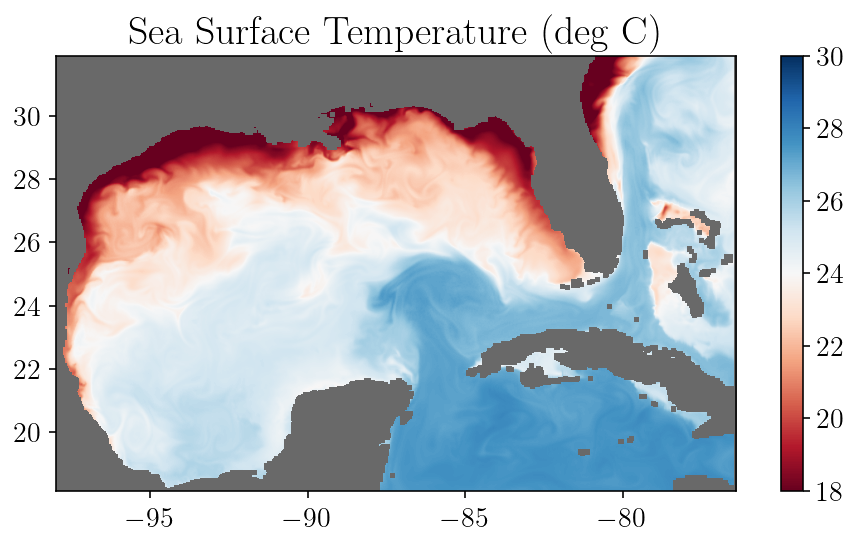

In [4]:
# Sea surface temperature
    
field = np.reshape(sst[:, :, 0], [ny, nx])
plt.figure(figsize=(8, 4))
gom_plot(lon, lat, field, vmin=18, vmax=30)
plt.title('Sea Surface Temperature (deg C)')
plt.colorbar()
plt.show()

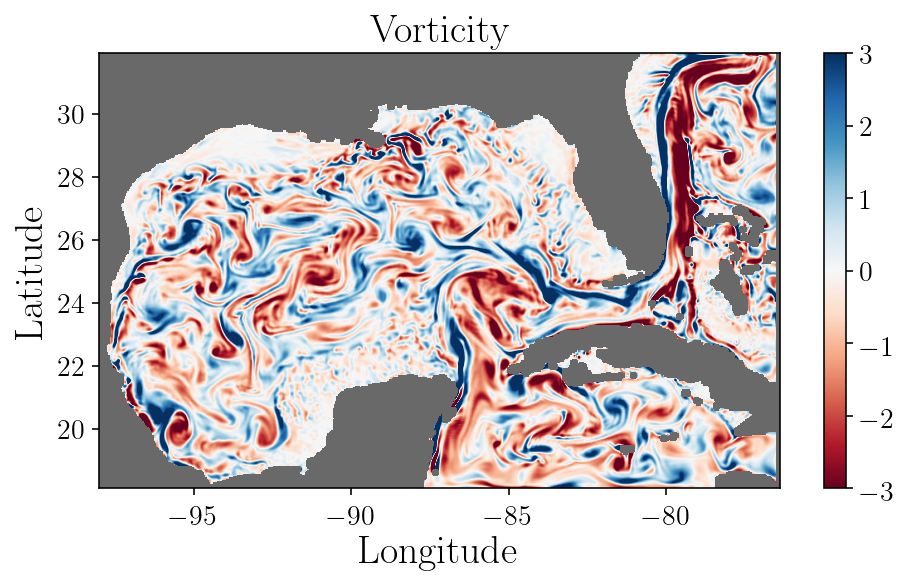

In [5]:
# Vorticity
    
field = np.reshape(vort[:, 1], [ny, nx], order='F')
plt.figure(figsize=(8, 4))
gom_plot(lon, lat, field, vmin=-3, vmax=3)
plt.title('Vorticity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.show()

# 1. Equation space representation

In [6]:
# Finite differences of velocity
idx = 1 # Which field to use

u = uvel[:, :, idx]
v = vvel[:, :, idx]

# Have to be a little careful... latitudinal variation means grid is nonuniform

# Zonal derivative
ux = np.zeros(u.shape)
vx = np.zeros(u.shape)
for i in range(len(lat)):
    ux[i, :] = np.gradient(u[i, :], dx[i])
    vx[i, :] = np.gradient(v[i, :], dx[i])
    
# Meridional derivative
uy = np.zeros(u.shape)
vy = np.zeros(u.shape)
y = np.cumsum(dx)
for i in range(len(lon)):
    uy[:, i] = np.gradient(u[:, i], y)
    vy[:, i] = np.gradient(v[:, i], y)


In [7]:
# Pressure gradient from other terms
ut = (uvel[:, :, idx+1] - uvel[:, :, idx])/(dt)
vt = (vvel[:, :, idx+1] - vvel[:, :, idx])/(dt)

# Material derivatives
Du = ut + u*ux + v*uy;
Dv = vt + u*vx + v*vy;

# Coriolis forces
cor_u = (f*v.T).T
cor_v = -(f*u.T).T
px = -rho*(Du + cor_u)
py = -rho*(Dv + cor_v)

Stack terms to make 2D cluster model

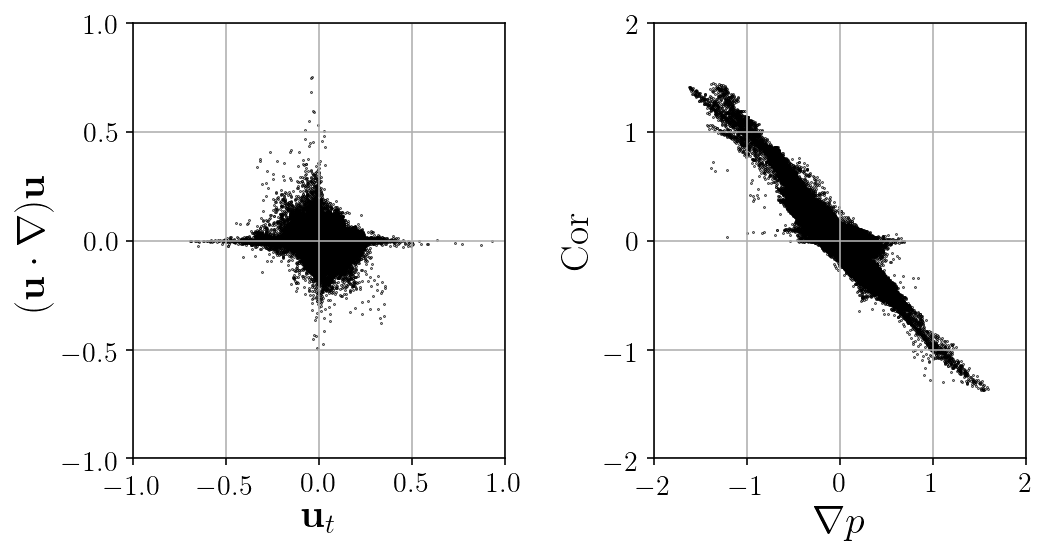

In [8]:
# Plot views of feature space (4D)
u_features = np.vstack([ut.flatten('F'), (u*ux + v*uy).flatten('F'),
                     (px/rho).flatten('F'), cor_u.flatten('F')]).T

v_features = np.vstack([vt.flatten('F'), (u*vx + v*vy).flatten('F'),
                     (py/rho).flatten('F'), cor_v.flatten('F')]).T

labels = [r'$\mathbf{u}_t$', r'$(\mathbf{u} \cdot \nabla) \mathbf{u}$', r'$\nabla p$', 'Cor']

mask = np.logical_not(np.any(np.isnan(u_features), axis=1)).flatten('F') * np.logical_not(np.any(np.isnan(v_features), axis=1)).flatten('F')
u_features = u_features[mask, :]
v_features = v_features[mask, :]

features = np.vstack([u_features, v_features])

# Scaling factor to make the GMM work better (order 1)
scale = 1e-4
features = features/scale

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(features[:, 0], features[:, 1], .1, 'k')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.grid()

plt.subplot(122)
plt.scatter(features[:, 2], features[:, 3], .1, 'k')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel(labels[2])
plt.ylabel(labels[3])
plt.grid()

plt.subplots_adjust(wspace=0.4)
plt.show()

We can immediately see a strong signature of balance between pressure gradient and Coriolis forces

# 2. Gaussian mixture model

3315088937


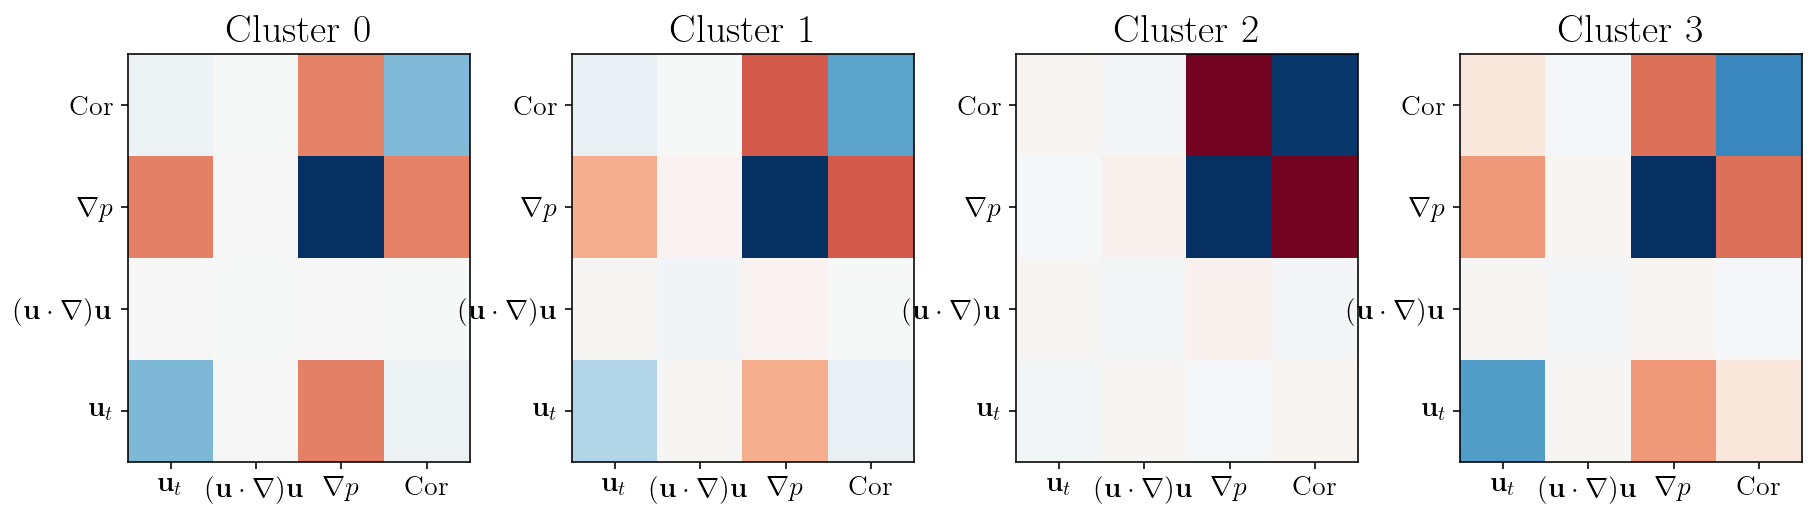

In [9]:
# Fit to GMM and plot covariance matrices
nc = 4
nfeatures = features.shape[1]

seed = np.random.randint(2**32)
seed = 3315088937 
print(seed)
model = GaussianMixture(n_components=nc, random_state=seed)
model.fit(features)

# Plot covariance matrices
plt.figure(figsize=(15, 9))
for i in range(nc):
    plt.subplot(2, 4, i+1)
    C = model.covariances_[i, :, :] # Restrict to real part
    plt.pcolor(C, vmin=-max(abs(C.flatten())), vmax=max(abs(C.flatten())), cmap='RdBu')
    plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_yticks(np.arange(0.5, nfeatures+0.5))
    plt.gca().set_xticklabels(labels)
    plt.gca().set_yticklabels(labels)
    plt.gca().set_title('Cluster {0}'.format(i))
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
plt.show()

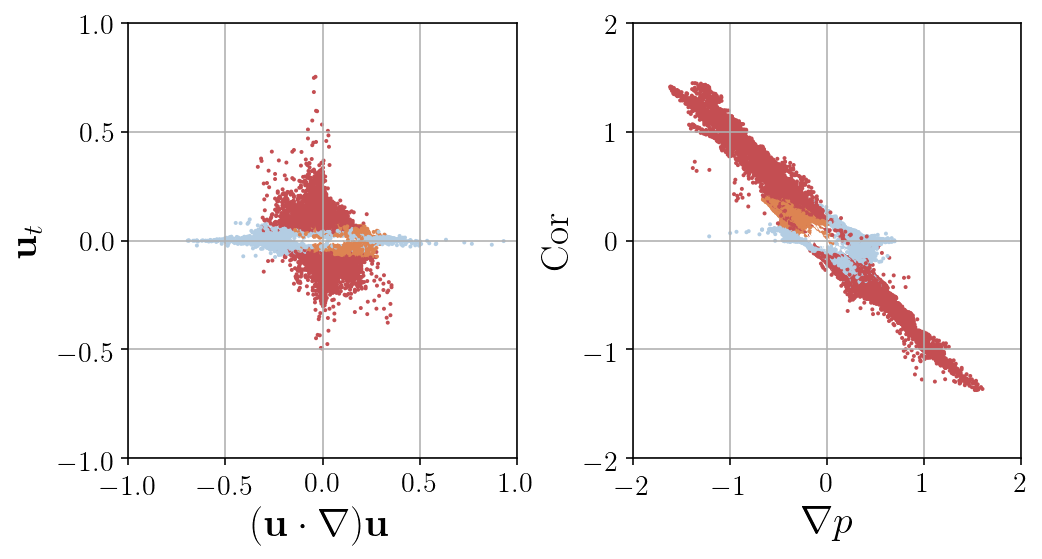

In [10]:
# Predict clusters for a single snapshot
cluster_idx = model.predict(features);

# 2D views of feature space
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(features[:, 0], features[:,1], 1, cluster_idx, cmap=cm)
plt.ylabel(labels[0], fontsize=20)
plt.xlabel(labels[1], fontsize=20)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.clim([-0.5, cm.N-0.5])
plt.grid()

plt.subplot(122)
plt.scatter(features[:, 2], features[:,3], 1, cluster_idx, cmap=cm)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel(labels[2], fontsize=20)
plt.ylabel(labels[3], fontsize=20)
plt.clim([-0.5, cm.N-0.5])
plt.grid()

plt.subplots_adjust(wspace=0.3)
plt.show()

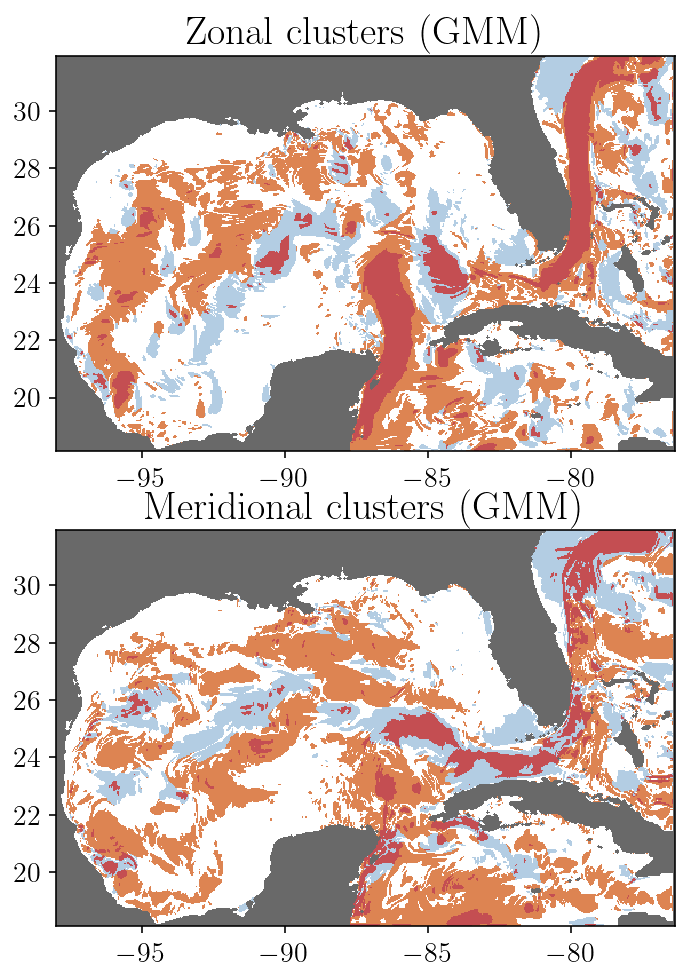

In [11]:
# Colormap of clusters

plt.figure(figsize=(8, 8))
plt.subplot(211)

# Zonal clusters
clustermap = np.zeros([nx*ny])
clustermap[mask.flatten('C')] = cluster_idx[:sum(mask)]  # Index into unmasked regions
clustermap[np.logical_not(mask)] = np.NaN
clustermap = np.reshape(clustermap, [ny, nx], order='F')

plt.imshow(clustermap, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
          extent=[min(lon), max(lon), min(lat), max(lat)])
plt.title('Zonal clusters (GMM)')

plt.subplot(212)

# Meridional clusters
clustermap = np.zeros([nx*ny])
clustermap[mask.flatten('C')] = cluster_idx[sum(mask):]  # Index into unmasked regions
clustermap[np.logical_not(mask)] = np.NaN
clustermap = np.reshape(clustermap, [ny, nx], order='F')

plt.imshow(clustermap, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
          extent=[min(lon), max(lon), min(lat), max(lat)])
plt.title('Meridional clusters (GMM)')
plt.show()

# 3. SPCA Reduction

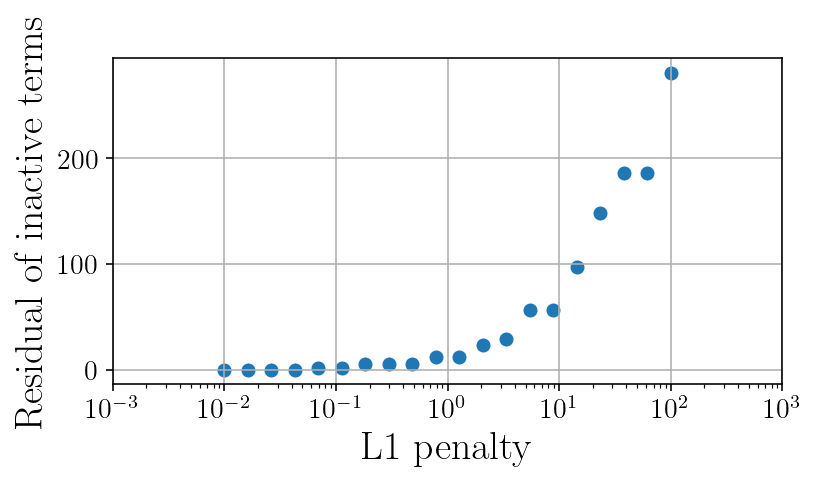

In [12]:
# Sparse PCA to identify directions of nonzero variance
#   First step: model selection for L1 regularization
alphas = np.logspace(-2, 2, 20)
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        cluster_features = features[feature_idx, :nfeatures]  
        spca = SparsePCA(n_components=1, alpha=alphas[k], normalize_components=True)
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
        
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel('L1 penalty')
plt.ylabel('Residual of inactive terms')
plt.gca().set_xscale('log')
plt.xlim([1e-3, 1e3])
plt.grid()
plt.show()

In [13]:
alpha_opt = 10

spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :nfeatures]
    spca = SparsePCA(n_components=1, alpha=alpha_opt, normalize_components=True)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    print(active_terms)
    spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    

GMM Cluster 0:
[0 2 3]
GMM Cluster 1:
[0 2 3]
GMM Cluster 2:
[2 3]
GMM Cluster 3:
[0 2]


# 4. Final dominant balance models

In [14]:
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]
print(balance_models)

for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    print(active_terms)

# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
u_balancemap = np.zeros([nx*ny, 1])
u_balancemap[mask, 0] = balance_idx[:sum(mask)]
u_balancemap[np.logical_not(mask), 0] = np.NaN
u_balancemap = np.reshape(u_balancemap, [ny, nx], order='F')

balance_idx = np.array([model_index[i] for i in cluster_idx])
v_balancemap = np.zeros([nx*ny, 1])
v_balancemap[mask, 0] = balance_idx[sum(mask):]
v_balancemap[np.logical_not(mask), 0] = np.NaN
v_balancemap = np.reshape(v_balancemap, [ny, nx], order='F')

[[0. 0. 1. 1.]
 [1. 0. 1. 0.]
 [1. 0. 1. 1.]]
SPCA Cluster 0:
[2 3]
SPCA Cluster 1:
[0 2]
SPCA Cluster 2:
[0 2 3]


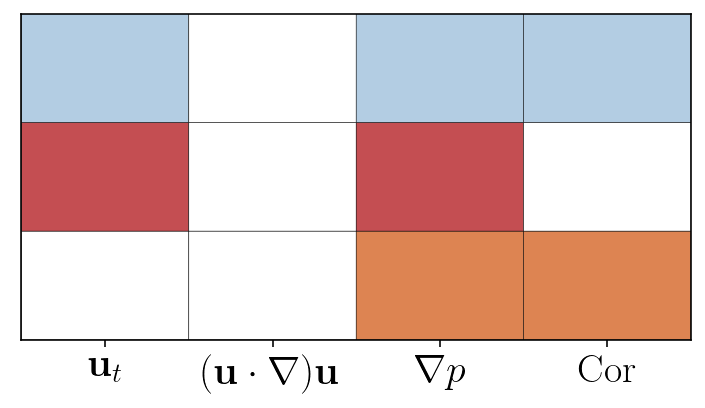

In [15]:
gridmap = balance_models.copy()
gridmask = gridmap==0
gridmap = (gridmap.T*np.arange(nmodels)).T+1  # Scale map so that active terms can be color-coded
gridmap[gridmask] = 0

plt.figure(figsize=(6, 3))
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k')
plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
plt.gca().set_xticklabels(labels, fontsize=20)
plt.gca().set_yticks([])
plt.show()

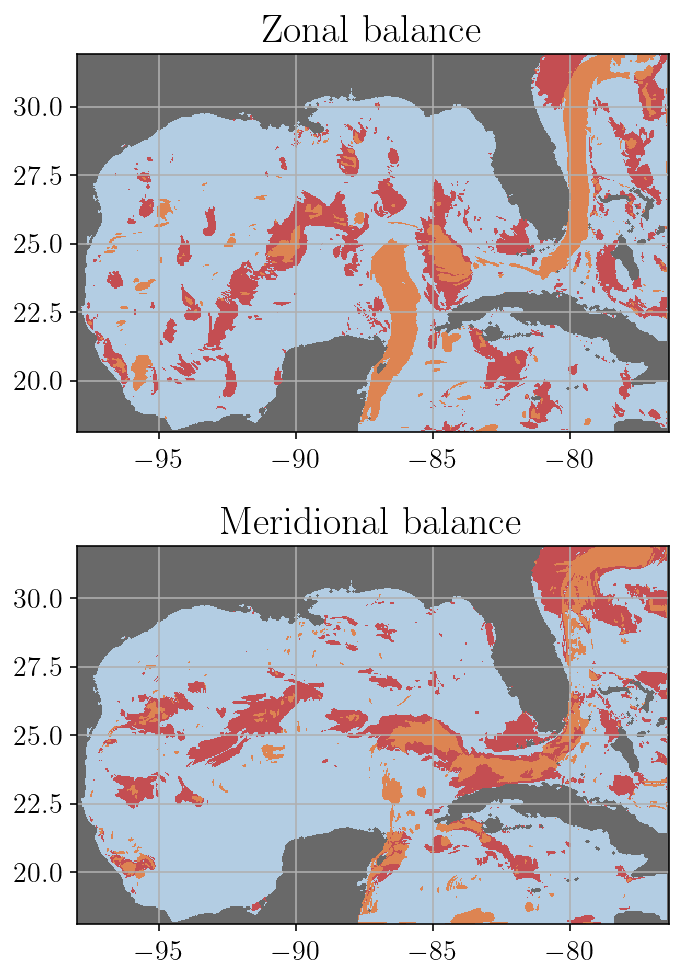

In [16]:
# Visualize fields

plt.figure(figsize=(8, 8))
plt.subplot(211)

plt.imshow(u_balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
          extent=[min(lon), max(lon), min(lat), max(lat)])
plt.grid()
plt.title('Zonal balance')

plt.subplot(212)

plt.imshow(v_balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
          extent=[min(lon), max(lon), min(lat), max(lat)])
plt.grid()
plt.title('Meridional balance')

plt.subplots_adjust(hspace=0.3)
plt.show()